# Inference: No-U-Turn MCMC

This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using [No-U-Turn Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/nuts_mcmc.html).


First, we create a simple normal distribution

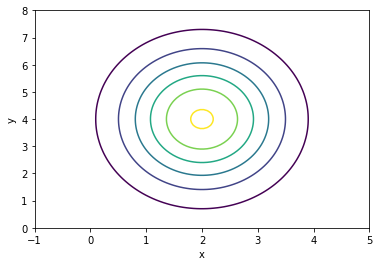

In [3]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up and run a sampling routine using Hamiltonian MCMC

In [10]:
# Choose starting points for 3 mcmc chains
xs = [
    [2, 1],
    [3, 3],
    [5, 4],
]

# Set a standard deviation, to give the method a sense of scale
#sigma = [1, 1]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.NoUTurnMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     39      0:00.0
1     51      0:00.0
2     57      0:00.0
3     63      0:00.0
100   921     0:00.1
200   1773    0:00.1
300   2805    0:00.2
400   3693    0:00.2
500   4509    0:00.3
600   5493    0:00.3
700   6393    0:00.4
800   7305    0:00.4
900   8131    0:00.5
1000  8449    0:00.5
Halting: Maximum number of iterations (1000) reached.
Done!


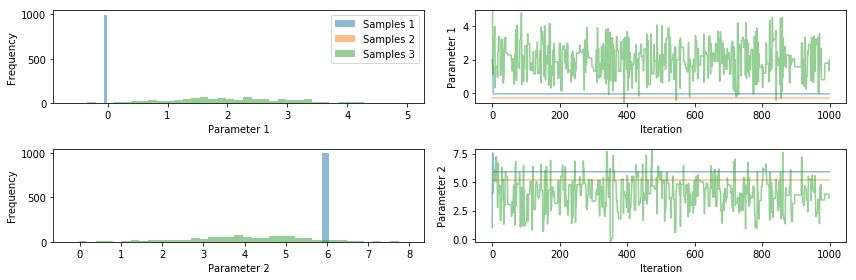

In [11]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[4.273235398370196, 1.148444325419373]
0.049525149762508436
nan
inf


/home/mrobins/git/pints/pints/toy/_gaussian.py:121: RuntimeWarning: invalid value encountered in log
  dkl3 = np.log(np.linalg.det(s1) / np.linalg.det(s0))
/home/mrobins/git/pints/pints/toy/_gaussian.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  dkl3 = np.log(np.linalg.det(s1) / np.linalg.det(s0))


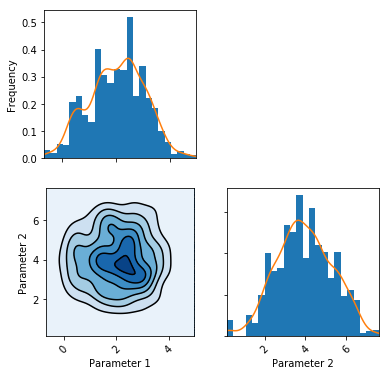

In [7]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

## No-U-Turn MCMC on a time-series problem

We now try the same method on a time-series problem

First, we try it in 1d, using a wrapper around the LogisticModel to make it one-dimensional.

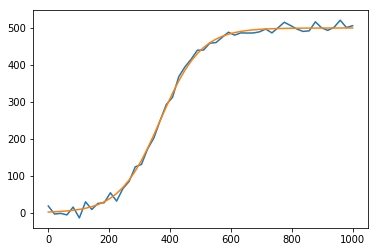

In [12]:
import pints.toy as toy

# Create a wrapper around the logistic model, turning it into a 1d model
class Model(pints.ForwardModel):
    def __init__(self):
        self.model = toy.LogisticModel()
    def simulate(self, x, times):
        return self.model.simulate([x[0], 500], times)
    def simulateS1(self, x, times):
        values, gradient = self.model.simulateS1([x[0], 500], times)
        gradient = gradient[:, 0]
        return values, gradient
    def n_parameters(self):
        return 1

# Load a forward model
model = Model()
    
# Create some toy data
real_parameters = np.array([0.015])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.figure()
plt.plot(times, values)
plt.plot(times, org_values)
plt.show()

We can use optimisation to find the parameter value that maximises the loglikelihood, and note that it's become slightly biased due to noise.

In [13]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Find the best parameters with XNES
best_parameters, fx = pints.optimise(log_likelihood, real_parameters, method=pints.XNES)
print(best_parameters[0])

Maximising LogPDF
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 4
Iter. Eval. Best      Time m:s
0     4     -374.2353   0:00.0
1     8     -374.2353   0:00.0
2     12    -335.1027   0:00.0
3     16    -190.6176   0:00.0
20    84    -184.5913   0:00.0
40    164   -184.5911   0:00.0
60    244   -184.5911   0:00.0
80    324   -184.5911   0:00.0
100   404   -184.5911   0:00.0
120   484   -184.5911   0:00.0
140   564   -184.5911   0:00.1
160   644   -184.5911   0:00.1
180   724   -184.5911   0:00.1
200   804   -184.5911   0:00.1
220   884   -184.5911   0:00.1
240   964   -184.5911   0:00.1
249   996   -184.5911   0:00.1
Halting: No significant change for 200 iterations.
0.014993608593413373


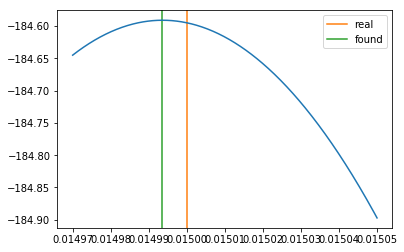

In [14]:
# Show the likelihood near the true parameters
plt.figure()
x = np.linspace(0.01497, 0.01505, 500)
y = [log_likelihood([i]) for i in x]
plt.axvline(real_parameters[0], color='tab:orange', label='real')
plt.axvline(best_parameters[0], color='tab:green', label='found')
plt.legend()
plt.plot(x, y)
plt.show()

Because the LogisticModel (and our wrapper) support the `evaluatS1()` method, we can also evaluate the gradient of the loglikelihood at different points:

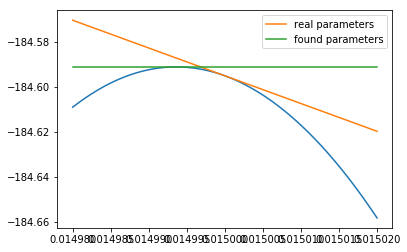

In [15]:
# Show derivatives at two points
y1, dy1 = log_likelihood.evaluateS1(real_parameters)
y2, dy2 = log_likelihood.evaluateS1(best_parameters)

# Show the likelihood near the true parameters
x = np.linspace(0.01498, 0.01502, 500)
y = [log_likelihood([i]) for i in x]
z1 = y1 + (x - real_parameters[0]) * dy1
z2 = y2 + (x - best_parameters[0]) * dy2

plt.figure()
plt.plot(x, y)
plt.plot(x, z1, label='real parameters')
plt.plot(x, z2, label='found parameters')
plt.legend()
plt.show()

Satisfied that this works, we now run a NoUTurnMCMC routine (which uses the derivative information)

In [16]:
# Choose starting points for mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
#sigma0 = (best_parameters - real_parameters) * 0.1
sigma0 = np.abs(real_parameters)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01],
    [0.02]
)

# Make posterior
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.NoUTurnMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Set small step size
# for sampler in mcmc.samplers():
#     sampler.set_leapfrog_step_size(3e-5)   # This is very sensitive!

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     93      0:00.0
1     99      0:00.0
2     105     0:00.0
3     111     0:00.0
100   933     0:00.1
200   1905    0:00.2


/home/mrobins/git/pints/pints/toy/_logistic_model.py:76: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
/home/mrobins/git/pints/pints/toy/_logistic_model.py:83: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
/home/mrobins/git/pints/pints/toy/_logistic_model.py:85: RuntimeWarning: invalid value encountered in true_divide
  (self._p0 * (c * exp + 1)**2) + 1 / (c * exp + 1)
/home/mrobins/git/pints/pints/_mcmc/_nuts.py:127: RuntimeWarning: divide by zero encountered in double_scalars
  while ratio**alpha > 2**(-alpha):
/home/mrobins/git/pints/pints/toy/_logistic_model.py:83: RuntimeWarning: overflow encountered in multiply
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
/home/mrobins/git/pints/pints/toy/_logistic_model.py:83: RuntimeWarning: overflow encountered in square
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
/home/mrobins/git/pints/pints/toy/_logistic_model.py:84

300   2889    0:00.3
400   3801    0:00.4
500   4683    0:00.4
600   5637    0:00.5
700   6193    0:00.6
800   6505    0:00.6
900   6821    0:00.6
1000  7111    0:00.7
Halting: Maximum number of iterations (1000) reached.
Done!


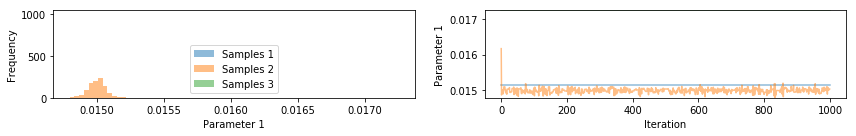

In [17]:
# Show trace and histogram
pints.plot.trace(chains)
plt.show()

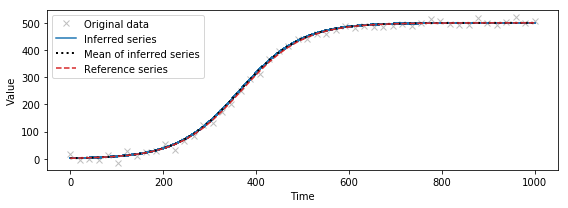

In [18]:
# Show predicted time series for the first chain
pints.plot.series(chains[0, 200:], problem, real_parameters)
plt.show()

## 2d Time series

Finally, we try No-U-Turn MCMC on a 2d logistic model problem:

In [19]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.NoUTurnMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     15      0:00.0
1     21      0:00.0
2     27      0:00.0
3     33      0:00.0
100   615     0:00.1
200   1215    0:00.1
300   1815    0:00.2


/home/mrobins/git/pints/pints/_mcmc/_nuts.py:125: RuntimeWarning: invalid value encountered in double_scalars
  ratio = p_theta_r_dash/p_theta_r
/home/mrobins/git/pints/pints/_mcmc/_nuts.py:97: RuntimeWarning: divide by zero encountered in log
  s_dash = int(np.log(u) < Delta_max + hamiltonian)


400   2415    0:00.2
500   3015    0:00.3
600   3615    0:00.4
700   4215    0:00.4
800   4815    0:00.5
900   5415    0:00.5
1000  6009    0:00.6
Halting: Maximum number of iterations (1000) reached.
Done!


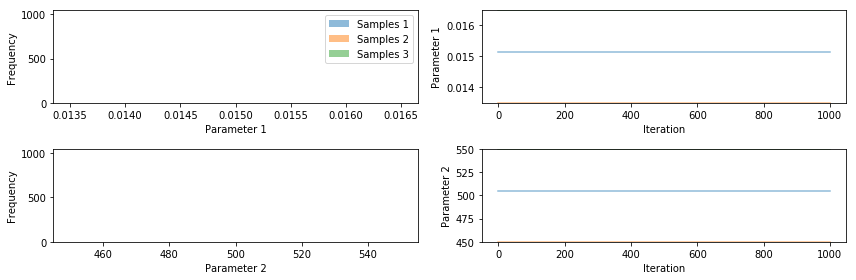

In [20]:
# Show traces and histograms
pints.plot.trace(chains)
plt.show()

Chains have converged!

In [21]:
# Discard warm up
chains = chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

R-hat:
[499748377122080.9, inf]


/home/mrobins/git/pints/pints/_diagnostics.py:106: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt((W + (1.0 / t) * (B - W)) / W)


Extract any divergent iterations